In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
from abc import abstractmethod, ABC
from fastai2.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2

from htools import *
from img_wang.data import MixupDataset, load_img, get_databunch
from incendio.callbacks import TorchCallback, MetricHistory
from incendio.core import Trainer, BaseModel
from incendio.layers import ConvBlock, ResBlock, mish, Mish

/Users/hmamin/anaconda3/lib/python3.7/site-packages/incendio/callbacks.py:24: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


In [4]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [5]:
dir_u = Path('data/imagewang-160/unsup/')

In [440]:
bs = 2
dst, dsv, dlt, dlv = get_mixup_databunch(dir_u, bs=bs)

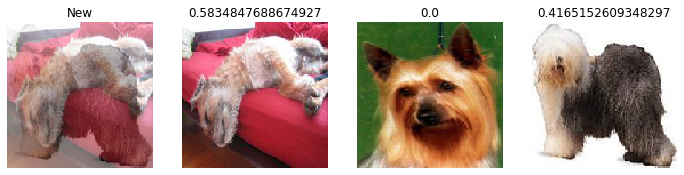

In [31]:
*imgs, w = dst[0]
show_images(imgs, figsize=(12, 4), titles=['New']+w.tolist())
plt.show()

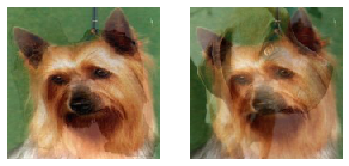

In [7]:
*xb, yb = next(iter(dlt))
show_images(xb[0])

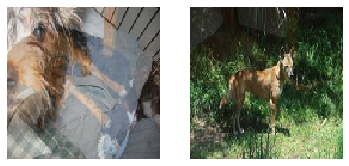

In [8]:
dst.shuffle()
*xb, yb = next(iter(dlt))
show_images(xb[0])

In [9]:
xb[0].shape

torch.Size([2, 3, 128, 128])

In [10]:
yb

tensor([[0.5806, 0.4194, 0.0000],
        [0.1453, 0.0000, 0.8547]], dtype=torch.float64)

In [11]:
len(xb)

4

In [12]:
conv = nn.Conv2d(3, 5, 3)
fc = nn.AdaptiveAvgPool2d(1)
tmp = conv(xb[0])
tmp.shape

torch.Size([2, 5, 126, 126])

In [13]:
fc(tmp).squeeze().shape

torch.Size([2, 5])

torch.Size([8, 3, 128, 128])


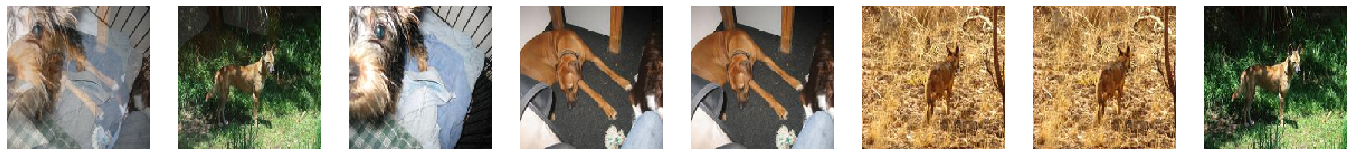

In [14]:
stk = torch.cat(xb, dim=0)
print(stk.shape)
show_images(stk)

In [15]:
tmp = conv(stk)
tmp.shape

torch.Size([8, 5, 126, 126])

In [16]:
bs = 2
shape = tmp.shape
tmp.view(bs, shape[1]*shape[0]//bs, *shape[-2:]).shape

torch.Size([2, 20, 126, 126])

In [39]:
class UnmixerModel(nn.Module):
    
    def __init__(self, n=3, c_in=3, fs=(8, 16, 32, 64, 128, 256), 
                 strides=(2, 2, 1, 1, 1, 1), kernel_size=3, norm=True, 
                 padding=0, act=Mish(), res_blocks=0, temperature=1, 
                 **res_kwargs):
        super().__init__()
        if len(fs) != len(strides):
            raise ValueError('Strides and f_dims must be same length (1 '
                             ' value for each conv block).')
            
        self.n = n
        self.conv = nn.Sequential(
            *[ConvBlock(f_in, f_out, kernel_size=kernel_size, norm=norm,
                        activation=act, stride=stride, padding=padding) 
              for f_in, f_out, stride in zip((c_in, *fs), fs, strides)]
        )
        if res_blocks:
            self.res = nn.Sequential(*[ResBlock(c_in=fs[-1], **res_kwargs) 
                                       for _ in range(res_blocks)])
        self.pool = AdaptiveConcatPool2d(1)
        self.temp = temperature

    def forward(self, *xb):
        bs = xb[0].shape[0]
        # Stack along batch dimension so all images can be processed at once.
        xb = torch.cat(xb, dim=0)                    # (bs*(n+1), c, h, w)
        xb = self.conv(xb)                           # (bs*(n+1), f[-1], h, w)
        if hasattr(self, 'res'): xb = self.res(xb)   # No change in dims.
        xb = self.pool(xb).squeeze()                 # (bs*(n+1), emb_dim))
        xb = xb.view(bs, -1, xb.shape[-1])           # (bs, n+1, emb_dim)
        x_new, x_src = xb[:, 0, :], xb[:, 1:, :]
        xb = (x_new.unsqueeze(1) * x_src).sum(-1)    # (bs, n)
        return F.softmax(xb/self.temp, dim=-1)

In [418]:
AdaptiveConcatPool2d(1)(torch.randn(2, 3, 4, 4)).shape

torch.Size([2, 6, 1, 1])

In [6]:
# # Troubleshooting UnmixerModel. Take simpler approach by just encoding each x image separately.
# # Trying to figure out if my batching strategy is causing the failure to learn.
# class Encoder(nn.Module):
    
#     def __init__(self, n=3, c_in=3, fs=(8, 16, 32, 64, 128, 256), 
#                  strides=(2, 2, 1, 1, 1, 1), kernel_size=3, norm=True, 
#                  padding=0, act=Mish(), res_blocks=0, temperature=1, 
#                  **res_kwargs):
#         super().__init__()
#         if len(fs) != len(strides):
#             raise ValueError('Strides and f_dims must be same length (1 '
#                              ' value for each conv block).')
            
#         self.n = n
#         self.conv = nn.Sequential(
#             *[ConvBlock(f_in, f_out, kernel_size=kernel_size, norm=norm,
#                         activation=act, stride=stride, padding=padding) 
#               for f_in, f_out, stride in zip((c_in, *fs), fs, strides)]
#         )
#         if res_blocks:
#             self.res = nn.Sequential(
#                 *[ResBlock(c_in=fs[-1], activation=act, **res_kwargs) 
#                   for _ in range(res_blocks)]
#             )
#         self.pool = AdaptiveConcatPool2d(1)
#         self.temp = temperature

#     def _forward(self, x):
#         x = self.conv(x)                             # (bs, f[-1], h, w)
#         if hasattr(self, 'res'): x = self.res(x)     # No change in dims.
#         return self.pool(x).squeeze(-1).squeeze(-1)  # (bs, emb_dim))
    
#     def forward(self, *xb):
#         x_new, *x = [self._forward(x) for x in xb]
#         x = torch.stack(x, dim=1)
#         print('forward', x_new.shape, x.shape)
#         x = (x_new.unsqueeze(1) * x).sum(-1)
#         return F.softmax(x/self.temp, dim=-1)
    
    
# Version of encoder that can be passed to Unmixer as the encoder arg.
class Encoder(nn.Module):
    
    def __init__(self, n=3, c_in=3, fs=(8, 16, 32, 64, 128, 256), 
                 strides=(2, 2, 1, 1, 1, 1), kernel_size=3, norm=True, 
                 padding=0, act=Mish(), res_blocks=0, **res_kwargs):
        super().__init__()
        if len(fs) != len(strides):
            raise ValueError('Strides and f_dims must be same length (1 '
                             ' value for each conv block).')
            
        self.n = n
        self.conv = nn.Sequential(
            *[ConvBlock(f_in, f_out, kernel_size=kernel_size, norm=norm,
                        activation=act, stride=stride, padding=padding) 
              for f_in, f_out, stride in zip((c_in, *fs), fs, strides)]
        )
        if res_blocks:
            self.res = nn.Sequential(
                *[ResBlock(c_in=fs[-1], activation=act, **res_kwargs) 
                  for _ in range(res_blocks)]
            )

    def forward(self, ˜x):
        x = self.conv(x)                             # (bs, f[-1], h, w)
        if hasattr(self, 'res'): x = self.res(x)     # No change in dims.
        return x

In [205]:
# class Unmixer(nn.Module):
    
#     @valuecheck
#     def __init__(self, encoder, temperature=1.0, 
#                  last_act:('sigmoid', 'softmax')='sigmoid'):
#         super().__init__()
#         self.encoder = encoder
#         self.pool = AdaptiveConcatPool2d(1)
#         self.last_act = torch.sigmoid if last_act == 'sigmoid' \
#             else partial(F.softmax, dim=-1)
#         self.temp = temperature
        
#     def forward(self, *xb):
#         x_new, *x = [self.pool(self.encoder(x)).squeeze(-1).squeeze(-1)
#                      for x in xb]
#         x = torch.stack(x, dim=1)
#         x = (x_new[:, None, ...] * x).sum(-1)
#         return self.last_act(x/self.temp)

class Unmixer(BaseModel):
    
    def __init__(self, encoder=None, head=None):
        super().__init__()
        self.encoder = encoder or Encoder()
        self.pool = AdaptiveConcatPool2d(1)
        self.head = head or DotProductHead()
        
    def forward(self, *xb):
        x_new, *x = [self.pool(self.encoder(x)).squeeze(-1).squeeze(-1)
                     for x in xb]
        x = torch.stack(x, dim=1)
        return self.head(x_new, x)

In [8]:
class SmoothSoftmax(nn.Module):
    
    def __init__(self, temperature='auto'):
        super().__init__()
        self.temperature = None if temperature == 'auto' else temperature
        
    def forward(self, x):
        t = self.temperature
        if not t:
            self.temperature = t = int(np.sqrt(x.shape[-1]))
        return x.div(t).softmax(dim=-1)

In [613]:
ss = SmoothSoftmax()
ss.temperature

In [614]:
_ = ss(x[0])
ss.temperature

11

In [9]:
class ClassificationHead(nn.Module, ABC):
    
    @valuecheck
    def __init__(self, last_act:('sigmoid', 'softmax')='sigmoid', 
                 temperature=1.0):
        super().__init__()
        if last_act == 'sigmoid':
            warnings.warn('Temperature is ignored when using sigmoid.')
            self.last_act = torch.sigmoid
        else:
            self.last_act = SmoothSoftmax(temperature)
        
    def forward(self, x_new, x_stack):
        x = self._forward(x_new, x_stack)
        return self.last_act(x)
    
    @abstractmethod
    def _forward(self, x_new, x_stack):
        raise NotImplementedError

In [32]:
class DotProductHead(ClassificationHead):
    
    @valuecheck
    def __init__(self, **act_kwargs):
        super().__init__(**act_kwargs)
        
    def _forward(self, x_new, x_stack):
        return (x_new[:, None, ...] * x_stack).sum(-1)

In [33]:
class MLPHead(ClassificationHead):
    
    @valuecheck
    def __init__(self, f_in, fs=(256, 1), act=Mish(), **act_kwargs):
        super().__init__(**act_kwargs)
        self.fc = nn.ModuleList([nn.Linear(f_in, f_out)
                                 for f_in, f_out in zip((f_in, *fs), fs)])
        self.act = act
        self.n_layers = len(fs)
        
    def _forward(self, x_new, x_stack):
        x = x_new[:, None, ...] * x_stack
        for i, layer in enumerate(self.fc, 1):
            x = layer(x)
            if i < self.n_layers:
                x = self.act(x)
        return x.squeeze(-1)

In [732]:
mlp = MLPHead(128, last_act='softmax')
mlp

MLPHead(
  (last_act): SmoothSoftmax()
  (fc): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=1, bias=True)
  )
  (act): Mish()
)

In [733]:
mlp(z1, z2)

tensor([[0.1030, 0.6052, 0.2918],
        [0.4986, 0.2519, 0.2495]], grad_fn=<SoftmaxBackward>)

In [673]:
x_new = xb[0]
x_stack = torch.stack(xb[1:], dim=1)
smap(x_new, x_stack)

[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 3, 128, 128])]

In [675]:
head = MLPHead()
res = head(x_new, x_stack)
res.shape

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Temperature is ignored when using sigmoid.
  import sys


torch.Size([2, 3, 3, 128, 128])

In [677]:
xb

[tensor([[[[0.7623, 0.7532, 0.6797,  ..., 0.0827, 0.0987, 0.1517],
           [0.7269, 0.7285, 0.7012,  ..., 0.1732, 0.0730, 0.0668],
           [0.6896, 0.6713, 0.6867,  ..., 0.3860, 0.0860, 0.0867],
           ...,
           [0.4918, 0.5214, 0.5276,  ..., 0.2777, 0.2662, 0.2553],
           [0.5214, 0.5204, 0.6053,  ..., 0.2816, 0.2773, 0.2598],
           [0.5061, 0.5262, 0.5997,  ..., 0.3027, 0.3001, 0.2826]],
 
          [[0.7003, 0.6935, 0.6268,  ..., 0.0827, 0.0987, 0.1517],
           [0.6649, 0.6688, 0.6483,  ..., 0.1732, 0.0730, 0.0668],
           [0.6276, 0.6116, 0.6406,  ..., 0.3860, 0.0860, 0.0867],
           ...,
           [0.5101, 0.5351, 0.5413,  ..., 0.2941, 0.2826, 0.2717],
           [0.5289, 0.5279, 0.6128,  ..., 0.2980, 0.2937, 0.2763],
           [0.5136, 0.5337, 0.6027,  ..., 0.3192, 0.3165, 0.2991]],
 
          [[0.6811, 0.6811, 0.6235,  ..., 0.0827, 0.0987, 0.1517],
           [0.6457, 0.6519, 0.6450,  ..., 0.1732, 0.0730, 0.0668],
           [0.6038, 0.59

In [693]:
z1 = net.pool(net.encoder(xb[0])).squeeze(-1).squeeze(-1)
z2 = torch.stack([net.pool(net.encoder(x_)).squeeze(-1).squeeze(-1) for x_ in xb[1:]], dim=1)
smap(z1, z2)

[torch.Size([2, 128]), torch.Size([2, 3, 128])]

In [689]:
len(xb)

4

In [698]:
z3 = (z1[:, None, ...] * z2)
z3.shape

torch.Size([2, 3, 128])

In [700]:
nn.Linear(128, 4)(z3).shape

torch.Size([2, 3, 4])

In [734]:
enet = Encoder(fs=[16, 64], strides=[2, 1], res_blocks=1)
enet

Encoder(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
  )
  (res): Sequential(
    (0): ResBlock(
      (layers): ModuleList(
        (0): ConvBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ConvBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [735]:
mlp = MLPHead(128)
mlp

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Temperature is ignored when using sigmoid.
  


MLPHead(
  (fc): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=1, bias=True)
  )
  (act): Mish()
)

In [736]:
net = Unmixer(enet, mlp)
net

Unmixer(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
    )
    (res): Sequential(
      (0): ResBlock(
        (layers): ModuleList(
          (0): ConvBlock(
            (block): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (1): ConvBlock(
            (block): Sequential(


In [737]:
res = net(*xb)

In [738]:
res.shape

torch.Size([2, 3])

In [739]:
res

tensor([[0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 1.0000]], grad_fn=<SigmoidBackward>)

In [41]:
# # (bs, n+1, enc_dim)
# xn, xs = net(*xb)
# xn.shape, xs.shape

res = net(*xb)
res.shape

torch.Size([2, 3])

In [42]:
res

tensor([[0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 0.0000]], grad_fn=<SoftmaxBackward>)

In [43]:
resnet = UnmixerModel(res_blocks=3)
resnet

UnmixerModel(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [44]:
res = resnet(*xb)

In [45]:
res

tensor([[1.0000e+00, 5.3775e-37, 0.0000e+00],
        [5.0000e-01, 5.0000e-01, 0.0000e+00]], grad_fn=<SoftmaxBackward>)

In [120]:
yb

tensor([[0.5806, 0.4194, 0.0000],
        [0.1453, 0.0000, 0.8547]], dtype=torch.float64)

In [128]:
F.mse_loss(res, yb, reduction='sum')

tensor(1.4579, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [130]:
(res - yb).pow(2).mean(1).sum(), (res - yb).pow(2).mean(1).mean(), (res - yb).pow(2).mean()

(tensor(0.4860, dtype=torch.float64, grad_fn=<SumBackward0>),
 tensor(0.2430, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2430, dtype=torch.float64, grad_fn=<MeanBackward0>))

In [46]:
class DatasetMixer(TorchCallback):
    
    def __init__(self, order=100):
        self.order = order
    
    def on_epoch_begin(self, trainer, epoch, val_stats):
        trainer.dl_train.dataset.shuffle()

## Test Tiny Trainer

In [740]:
paths_tiny = get_image_files(dir_u)[:12]
tdst, tdsv, tdlt, tdlv = get_mixup_databunch(paths=paths_tiny, train_pct=.5, 
                                             bs=2)
len(tdst), len(tdsv)

(4, 4)

In [741]:
for i, b in enumerate(tdlt):
    print(amap('shape', *b))

[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3])]
[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3])]


[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]
[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]


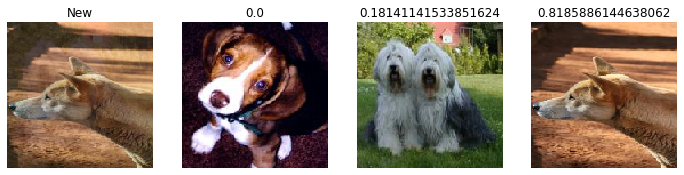

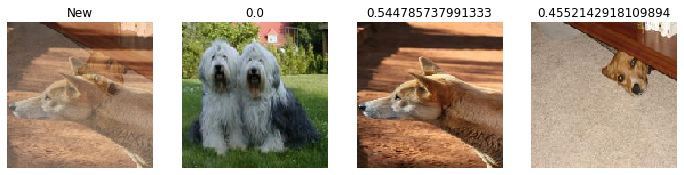

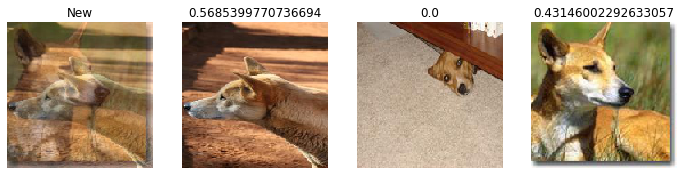

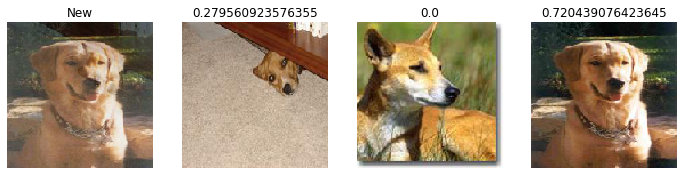

In [742]:
for i in range(len(tdst)):
    *x, y = tdst[i]
    print(amap('shape', *x))
    show_images(x, titles=['New']+y.tolist())

In [565]:
mnet = mobilenet_v2(pretrained=True)
mnet_enc = dict(mnet.named_children())['features']
mnet_unmix = Unmixer(mnet_enc, 1)

In [820]:
dict(mnet.named_children()).keys()

dict_keys(['features', 'classifier'])

In [422]:
mnet_unmix(*xb)

stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


tensor([[0., 1., 0.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward>)

In [567]:
enet = Unmixer(Encoder(fs=[8, 32], strides=[1, 1]), temperature=32)
enet

Unmixer(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
    )
  )
  (pool): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
)

In [743]:
T = Trainer(net, tdst, tdsv, tdlt, tdlv, F.mse_loss, mode='regression',
            out_dir='data/models/v0', 
            callbacks=[DatasetMixer(), MetricHistory()])

2020-08-10 22:48:07,551 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-10 22:48:09,221
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4696 |       0.1074 |

=====




2020-08-10 22:48:10,644
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1938 |       0.1058 |

=====




2020-08-10 22:48:13,089
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1842 |       0.1635 |

=====




2020-08-10 22:48:14,715
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1763 |       0.1714 |

=====




2020-08-10 22:48:16,591
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1757 |       0.1821 |

=====




2020-08-10 22:48:30,411
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2002 |       0.1887 |

=====




2020-08-10 22:48:32,573
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1772 |       0.1869 |

=====




2020-08-10 22:48:41,491
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1842 |       0.1900 |

=====




2020-08-10 22:48:50,737
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1833 |       0.1935 |

=====




2020-08-10 22:48:59,414
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2063 |       0.1915 |

=====




2020-08-10 22:49:01,077
 
=====

Epoch 10

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2006 |       0.1823 |

=====




2020-08-10 22:49:02,413
 
=====

Epoch 11

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1928 |       0.1847 |

=====




2020-08-10 22:49:17,804
 
=====

Epoch 12

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1866 |       0.1922 |

=====




2020-08-10 22:49:39,383
 
=====

Epoch 13

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1895 |       0.2180 |

=====




2020-08-10 22:50:02,432
 
=====

Epoch 14

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1844 |       0.1994 |

=====

2020-08-10 22:50:02,435
 Training complete. Model in eval mode.


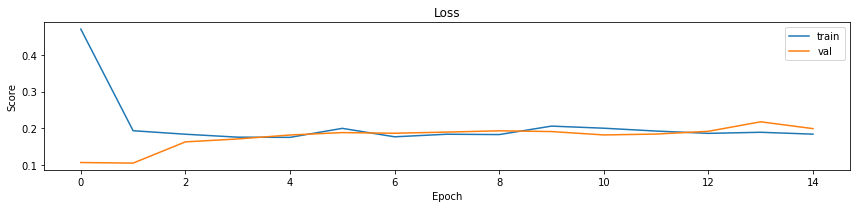

In [744]:
T.fit(15)

In [746]:
net(*xb)

tensor([[2.0787e-35, 3.9423e-35, 1.0716e-25],
        [1.8013e-38, 1.4054e-28, 1.4353e-36]], grad_fn=<SigmoidBackward>)

In [747]:
yb

tensor([[0.5806, 0.4194, 0.0000],
        [0.1453, 0.0000, 0.8547]], dtype=torch.float64)

## Scale Dataset Troubleshooting

In [232]:
paths_xtiny = get_image_files(dir_u)[:4]
sdst, sdsv, sdlt, sdlv = get_databunch(paths=paths_xtiny, mode='scale', bs=2, 
                                       train_pct=.5, n=1)

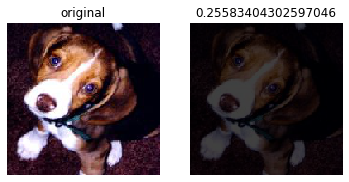

In [233]:
*x, y = sdst[0]
show_images(x, titles=['original']+y.tolist())

In [234]:
for *x, y in sdlv:
    print(amap('shape', *x), y.shape)

[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128])] torch.Size([2, 1])


In [235]:
# net = Unmixer(Encoder(fs=[8, 32], strides=[1, 1]),
#               MLPHead(64, last_act='softmax'))
# net

net = Unmixer()
net

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Temperature is ignored when using sigmoid.
  


Unmixer(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
      (2): ConvBlock(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Mish()
        )
      )
      (3): ConvBlock(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, e

In [236]:
net.weight_stats()

[(0.009, 0.106),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.004, 0.068),
 (1.0, 0.0),
 (0.0, 0.0),
 (-0.001, 0.048),
 (1.0, 0.0),
 (0.0, 0.0),
 (-0.0, 0.034),
 (1.0, 0.0),
 (0.0, 0.0),
 (-0.0, 0.024),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.017),
 (1.0, 0.0),
 (0.0, 0.0)]

In [244]:
net.weight_stats()

[(0.009, 0.106),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.004, 0.068),
 (1.0, 0.0),
 (0.0, 0.0),
 (-0.001, 0.048),
 (1.0, 0.0),
 (0.0, 0.0),
 (-0.0, 0.034),
 (1.0, 0.0),
 (0.0, 0.0),
 (-0.0, 0.024),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.017),
 (1.0, 0.0),
 (0.0, 0.0)]

In [237]:
net(*x), y

(tensor([[1.],
         [1.]], grad_fn=<SigmoidBackward>), tensor([[0.1510],
         [0.4523]]))

In [238]:
F.l1_loss(net(*x), y, reduction='mean')

tensor(0.6984, grad_fn=<L1LossBackward>)

In [239]:
nn.PairwiseDistance(2)(net(*x), y)

tensor([0.8490, 0.5477], grad_fn=<NormBackward1>)

In [240]:
nn.KLDivLoss(reduction='none')(net(*x), y)

tensor([[-0.4365],
        [-0.8111]], grad_fn=<KlDivBackward>)

In [241]:
nn.CosineEmbeddingLoss()(net(*x), y, target=torch.tensor(-1))

tensor(1., grad_fn=<MeanBackward0>)

In [242]:
T = Trainer(net, sdst, sdsv, sdlt, sdlv, F.mse_loss, mode='regression',
            out_dir='data/models/v0', callbacks=[MetricHistory()])

2020-08-12 21:59:55,340 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 10000
    weight_decay: 0
)




2020-08-12 21:59:55,887
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3384 |       0.4049 |

=====




2020-08-12 21:59:56,615
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2232 |       0.3118 |

=====




2020-08-12 21:59:57,210
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5053 |       0.4498 |

=====

2020-08-12 21:59:57,214
 Training complete. Model in eval mode.


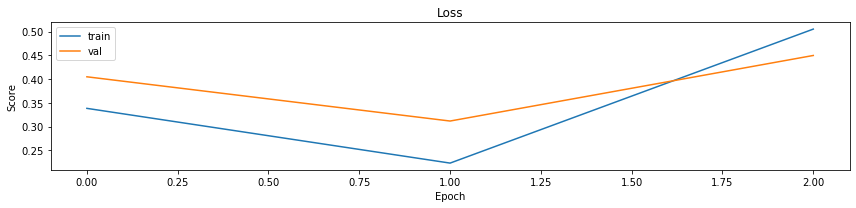

In [243]:
T.fit(3, 10000)

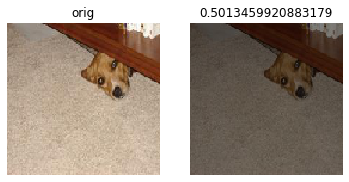

In [223]:
*x, y = next(iter(sdlt))
show_images([row[0] for row in x], titles=['orig']+y[0].tolist())

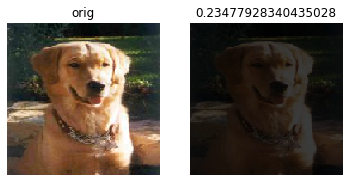

In [224]:
show_images([row[1] for row in x], titles=['orig']+y[1].tolist())

In [245]:
y

tensor([[0.1510],
        [0.4523]])

In [246]:
net(*x)

tensor([[0.9999],
        [0.9999]], grad_fn=<SigmoidBackward>)

In [162]:
for i, (*x, y) in enumerate(sdlv):
    yhat = net(*x)
    print(yhat)
    print(y)
    print(F.mse_loss(yhat, y), end='\n\n')

tensor([[9.6466e-01, 3.5343e-02],
        [1.0000e+00, 4.7205e-11]], grad_fn=<SoftmaxBackward>)
tensor([[0.5654, 0.4346],
        [0.8088, 0.1912]])
tensor(0.0980, grad_fn=<MseLossBackward>)



In [163]:
for i, (*x, y) in enumerate(sdlt):
    yhat = net(*x)
    print(yhat)
    print(y)
    print(F.mse_loss(yhat, y), end='\n\n')

tensor([[0.0011, 0.9989],
        [0.9933, 0.0067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4429, 0.5571],
        [0.5868, 0.4132]])
tensor(0.1803, grad_fn=<MseLossBackward>)

tensor([[1.2136e-01, 8.7864e-01],
        [1.0000e+00, 4.1624e-24]], grad_fn=<SoftmaxBackward>)
tensor([[0.4382, 0.5618],
        [0.8364, 0.1636]])
tensor(0.0636, grad_fn=<MseLossBackward>)

tensor([[8.7284e-07, 1.0000e+00],
        [1.3586e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward>)
tensor([[0.3367, 0.6633],
        [0.3988, 0.6012]])
tensor(0.1362, grad_fn=<MseLossBackward>)

tensor([[1.0000e+00, 3.9567e-14],
        [4.3329e-05, 9.9996e-01]], grad_fn=<SoftmaxBackward>)
tensor([[0.8030, 0.1970],
        [0.4072, 0.5928]])
tensor(0.1023, grad_fn=<MseLossBackward>)



In [91]:
F.mse_loss(net(*x), y)

tensor(0.5556, grad_fn=<MseLossBackward>)

## Scratch

Speed tests: bmm layer seems a bit slower than element-wise multiply.

In [178]:
%%timeit -n 25 -r 25
(res[0].unsqueeze(1) * res[1]).sum(-1)

The slowest run took 4.56 times longer than the fastest. This could mean that an intermediate result is being cached.
34.3 µs ± 16.8 µs per loop (mean ± std. dev. of 25 runs, 25 loops each)


In [179]:
%%timeit -n 25 -r 25
torch.bmm(res[0].unsqueeze(1), res[1].permute(0, 2, 1))

The slowest run took 42.03 times longer than the fastest. This could mean that an intermediate result is being cached.
68.6 µs ± 183 µs per loop (mean ± std. dev. of 25 runs, 25 loops each)
